# Image Classification to find novel anti-infectives
##### Individual Assignment - Computer Vision
##### June 2021

## Summary of Findings

##### **Purpose:**
The purpose of this exercise was to **set up a classification pipeline using classical computer vision and machine learning approaches** (no neural nets) that would **correctly predict dead from live roundworms C.elegans** to support finding a novel anti-infectives. The animals were exposed to the pathogen Enterococcus faecalis and either untreated or treated with ampicillin, a known antibiotic against the pathogen. The untreated worms display predominantly the "dead" pheotype: worms appear rod-like in shape and slightly uneven in texture. The treated (ampicillin, positive control) worms display predominantly the "live" phenotype: worms appear curved in shape and smooth in texture.

##### **Approach:**
1. The pipeline was built using a balanced dataset of 70 training images (35 in 
class `dead`, 35 in class `live`) and 30 test images. To establish a baseline, the images were loaded and without any further preprocessing put into a classic Decision Tree Classifier, obtaining an accuracy of approx. 90.5%. This served as our Baseline. 

2. As a next step, several classical computer vision preprocessing images were tested individually on the Dataset with the classic Decision Tree Classifier to assess whether the accuracy of the classifier would improve with preprocessing. All Classifiers used cross-validation, but default hyperparameters. The following preprocessing techniques were tested: 
- Image cropping
- Contrast improvement: Contrast Stretching, Histogram Equalization
- Image filtering: Sharpening, Blurring
- Edge detection: Laplacian, Sobel
- Morphological operations: Erosion,  Dilation, Opening and Closing
- Thresholding: Mean, Isodata, Otsu, Yen
- Segmentation

3. Next, several preprocessing techniques were combined in an effort to define the optimal image preprocessing pipeline. 

5. In a next step, the best-performing preprocessing technique was tried on several classical machine learning classifiers to identify the optimal classifier. 

4. Finally, the best performing model and preprocessing pipeline were chosen as winning model, saved and evaluated on the test data.

##### **Findings:**
The key finding was that **the model suffered from robustness**. Given the small training set, the model was very prone to overfitting during training and results for using different preprocessing methods varied widely and depended heavily on the random seed which determined training/test split, cross-validation as well as the classifier. As such, no single preprocessing technique was consistently found to be advantageous although among the ones that came up as outperforming the baseline (without any preprocessing) were thresholding and morphological operations. 

The best-performing preprocessing step during training (Image Cropping + Otsu Thresholding) heavily overfitted - during actual inference on the test data it predicted only live class and no dead class. 

##### **Next steps:**
- Increase training size to make training more robust
- Improve preprocessing pipeline (e.g. based on steps used in pipeline 3) to improve feature extraction
- Use Data Augmentation methods with creating new images to (a) ensure model never sees the same data twice during training, and (b) increase the training size if it is impossible to obtain more training data



---



## 1. Load & Prep Data

We load the training data from Google Drive.

In [386]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [387]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

Reading data from dead
Reading data from live
70 features
70 labels
2 classes: ['dead', 'live']


We have a balanced training dataset consisting of 35 images of each class (dead, live) and split this into a training and test (validation) set with a split of 70% training (49 images) and 30% test (21 images). We also set a random state for the test-train split as well as the classifiers to ensure that throughout this notebook, we have reproducible results.

In [388]:
# Verifying shape of the image arrays
print('Feature Shape:',features.shape)
print('Labels Shape:',labels.shape)

Feature Shape: (70, 361920)
Labels Shape: (70,)


In [389]:
# split into training and testing sets
from sklearn.model_selection import train_test_split

random_state= 24

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state= random_state)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)

Training records: 49
Test records: 21


Let's have a quick look at these images before we build our classifier - one from each class:

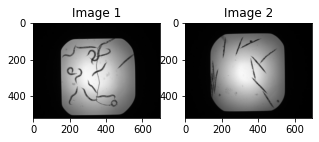

In [390]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage as sk
from skimage import io as sk_io
import cv2

images = []

live_image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))
images.append(live_image)
dead_image = cv2.imread(os.path.join(training_folder_name, "dead", "1649_1109_0003_Amp5-1_B_20070424_A23_w2_71C5704E-F745-4D29-B3B2-51216C02A45D.jpg"))
images.append(dead_image)

# Set up a figure of an appropriate size
fig = plt.figure(figsize=(5, 5))

image_num = 0
num_images = len(images)
# loop through the images
for image_idx in range(num_images):
    # Keep an incrementing count of each image
    a=fig.add_subplot(1, num_images, image_idx+1)
    # Add the image to the plot
    image_plot = plt.imshow(images[image_idx])
    # Add a caption with the folder name
    a.set_title("Image " + str(image_idx+1))
        
# Show the plot
plt.show()

We can clearly see the difference between the `live` class (image on the left) and the `dead` class (image on the right). 

## 2. Train a simple classifier - Baseline

We start out by training a simple classifier (DecisionTree Classifier) with cross-validation and default hyperparameters. Before training with the Decision Tree Classifier, we **normalize our images using MinMax scaler** so that they are scaled between 0 and 1 to prevent high-pixel density values to be dominating the model training.


In [391]:
# Defining function to compare models
import pandas as pd
import seaborn as sns
classifier_result = {}
def comparing_plot(d, label, new_training_score, new_test_score, ymin=0.50, ymax=1.0):
    d.update({label: [np.median(new_training_score),
                      np.median(new_test_score)]})
    plt.figure(figsize=(4,5));
    sns.set_palette("Paired")
    pd.DataFrame(d).set_index([pd.Index(["Training", "Validation"])]).plot.bar()
    plt.ylim(ymin, ymax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [392]:
# Define a function to train and evaluate the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold

# Our pipeline performs two tasks:
#   1. Normalize the image arrays
#   2. Train a classification model

classifier = DecisionTreeClassifier()
classifier_name = "Baseline_RF"

def train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier, classifier_name):
  # Convert the training and test features to floats so they can be scaled
  X_train_float = X_train.astype('float64')
  X_test_float = X_test.astype('float64')

  # Train and evaluate model 
  img_pipeline = Pipeline([('norm', MinMaxScaler()),
                            ('classify', classifier(random_state=random_state)),
                            ])

  # Use the pipeline to fit a model to the training data
  clf = img_pipeline.fit(X_train_float, Y_train)
  cv = StratifiedKFold(n_splits=10, random_state=random_state, shuffle=True)
  cv_scores = cross_val_score(clf, X_train_float, Y_train, scoring = "accuracy", cv = cv)
  predicted = accuracy_score(Y_test, clf.predict(X_test_float))

  # Evaluate classifier
  print('Classifier Metrics:', classifier)
    
  print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
  print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
  comparing_plot(classifier_result, classifier_name, np.median(cv_scores), np.median(predicted))
    
  #predictions = clf.predict(X_test_float)
  predictions = clf.predict(X_test_float)
  print(metrics.classification_report(Y_test, predictions, target_names=classnames))
  print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, clf.predict(X_test_float))))

  print("\n Confusion Matrix:")
  cm = confusion_matrix(Y_test, np.round(predictions, 0))
  # Plot confusion matrix as heatmap
  plt.figure(figsize=(3, 3))
  plt.imshow(cm, interpolation="nearest",cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(len(classnames))
  plt.xticks(tick_marks, classnames, rotation=85)
  plt.yticks(tick_marks, classnames)
  plt.xlabel("Predicted Label")
  plt.ylabel("True Label")
  plt.show()
  print('*******************************************************************')

Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 1.0000 (+/- 0.08)
Accuracy Test: 0.9048 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

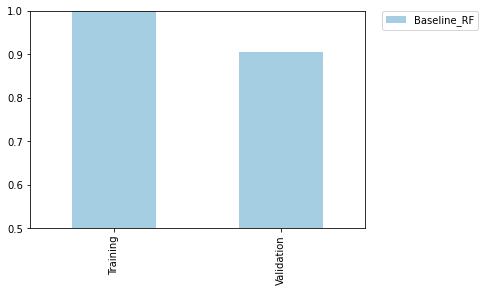

              precision    recall  f1-score   support

        dead       0.87      1.00      0.93        13
        live       1.00      0.75      0.86         8

    accuracy                           0.90        21
   macro avg       0.93      0.88      0.89        21
weighted avg       0.92      0.90      0.90        21

Accuracy: 90.48%

 Confusion Matrix:


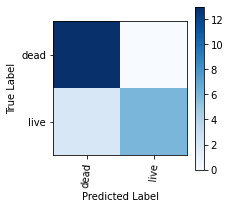

*******************************************************************


In [393]:
# Running our baseline classifier
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"Baseline_RF")

We get an accuracy score of 90.5% for our baseline model without any preprocessing of the images or tuning of hyperparameters. Let's see if we can do better through some preprocessing but before, let's have a look at model robustness by looking at the cross-validation scores for each run: 

In [394]:
# Run the baseline classifier outside of the function to access cv_scores:
# Convert the training and test features to floats so they can be scaled
X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

# Train and evaluate model 
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                            ('classify', DecisionTreeClassifier(random_state=random_state)),
                            ])

# Use the pipeline to fit a model to the training data
clf = img_pipeline.fit(X_train_float, Y_train)
cv_scores = cross_val_score(clf, X_train_float, Y_train, scoring = "accuracy", cv = 10)
predicted = accuracy_score(Y_test, clf.predict(X_test_float))

cv_scores

array([1.  , 1.  , 0.6 , 0.8 , 1.  , 1.  , 0.8 , 1.  , 1.  , 0.75])

Cross-validation takes our training set and randomly splits it into k equal parts (folds). Then it trains and evaluates the classifier model k times, picking a different fold for evaluation each time and training on the other k-1 folds. The result is an array containing the k evaluation scores (which we observe here with cv_scores). For evaluating model performance, the k results are usually averaged. Nevertheless, observing the array of k results gives us an idea of how robust the model is in terms of providing repeatedly similar performance across all k folds. 

## Appendix: Feature Engineering & Testing

Let's now see if we can improve our classification model by performing feature engineering. The underlying assumption is that we can transform our pictures such that the classifier is better able to distinguish differentiating features in the images and thus classification improves. 


Let's test the following preprocessing techniques:

- Contrast improvement: Contrast Stretching, Histogram Equalization
- Image filtering: Sharpening, Blurring
- Edge detection: Laplacian, Sobel
- Morphological operations: Erosion, Dilation, Opening and Closing
- Thresholding: Mean, Isodata, Otsu, Yen
- Segmentation

### 3.0 Crop Image to remove noisy background

However, before testing the features we will crop our images to remove the dark border around each. All images have a broad dark border around them, which could possibly destort results (e.g. the classifier could learn the exact size of the live and of the dead class and then classify just based on the border, which is however just an accidental feature based on how the images were recorded). We therefore apply manual cropping to reduce the border. 

The then applied feature preprocessings were all tested with image cropping and without image cropping and while results are not very robust, it appeared that some preprogressing techniques showed an improvement vs the baseline when images were cropped.  

(520, 696)

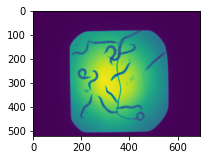

In [395]:
image = sk_io.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))
plt.figure(figsize=(3, 3))
plt.imshow(image)
image.shape

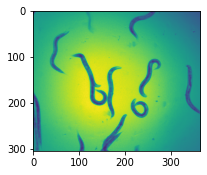

In [396]:
# Finding optimal cut-off points
#[140:450,160:550](optimal crop-off for live pic)
# [110:445,160:520] (optimal crop-off for dead pic)

# Load image
image = sk_io.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_B06_w2_2DC0E4E0-CCDF-4AA3-B655-DC27F2F2E59C.jpg"))
#image = cv2.imread(os.path.join(training_folder_name, "dead", "1649_1109_0003_Amp5-1_B_20070424_A20_w2_E9D674D9-524A-406B-9808-5F6689CADB5F.jpg"))

# Crop Image
cropped = image[140:445,160:525]

plt.figure(figsize=(3, 3))
plt.imshow(cropped)

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.24)
Accuracy Test: 0.7619 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

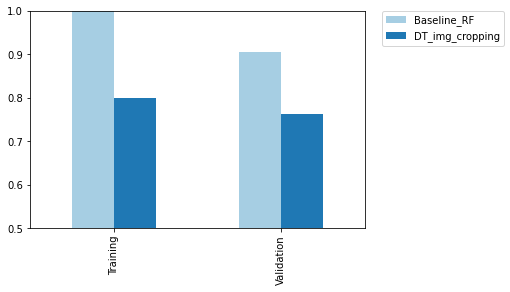

              precision    recall  f1-score   support

        dead       0.90      0.69      0.78        13
        live       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

Accuracy: 76.19%

 Confusion Matrix:


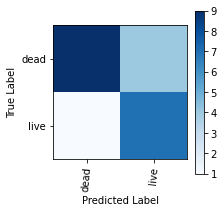

*******************************************************************


In [405]:
def prep_data_img_cropping (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                image_prepped = img[140:445,160:525]

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_img_cropping(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_img_cropping")

### 3.1 Contrast Improvement

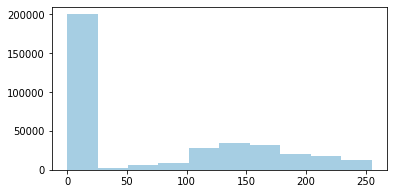

In [406]:
# Histogram of a random live pic
image = sk_io.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))
plt.figure(figsize=(6,3));
plt.hist(image.ravel())
plt.show() 

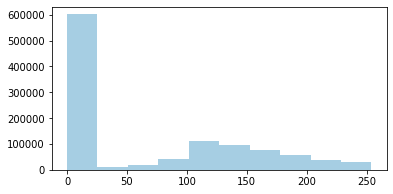

In [407]:
# Histogram of a random dead pic
image = cv2.imread(os.path.join(training_folder_name, "dead", "1649_1109_0003_Amp5-1_B_20070424_B22_w2_7D06CB6E-9CEC-4B80-BABD-89CCFD5D7D5B.jpg"))
plt.figure(figsize=(6,3));
plt.hist(image.ravel())
plt.show() 

We see that all images, dead or alive, use the entire intensity range (from 0 to 250), however have a very high concentration of pixels in the lowest range (0-25) and with only a small share of the pixels stretched across the pixel-range above 50. This is most likely due to the large black frame around each image.  

*Histogram equalization is a widely-used nonlinear transformation. It is achieved by using the Cumulative Distribution Function (CDF) of the image as the transformation function, after appropriate scaling of the ordinate axis to correspond to output GLs. Equalization refers to the fact that the histogram of the processed image is approximately uniform in density (number of pixels/GL). Because of the unimodal shape of most image histograms, equalization tends to automatically reduce the contrast in very light or dark areas and to expand the middle DNs toward the low and high ends of the GL scale. Where the CDF increases rapidly, the contrast gain also increases. The highest gain therefore occurs at DNs with the most pixels.* https://www.sciencedirect.com/topics/engineering/image-histogram

/usr/local/lib/python3.7/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)


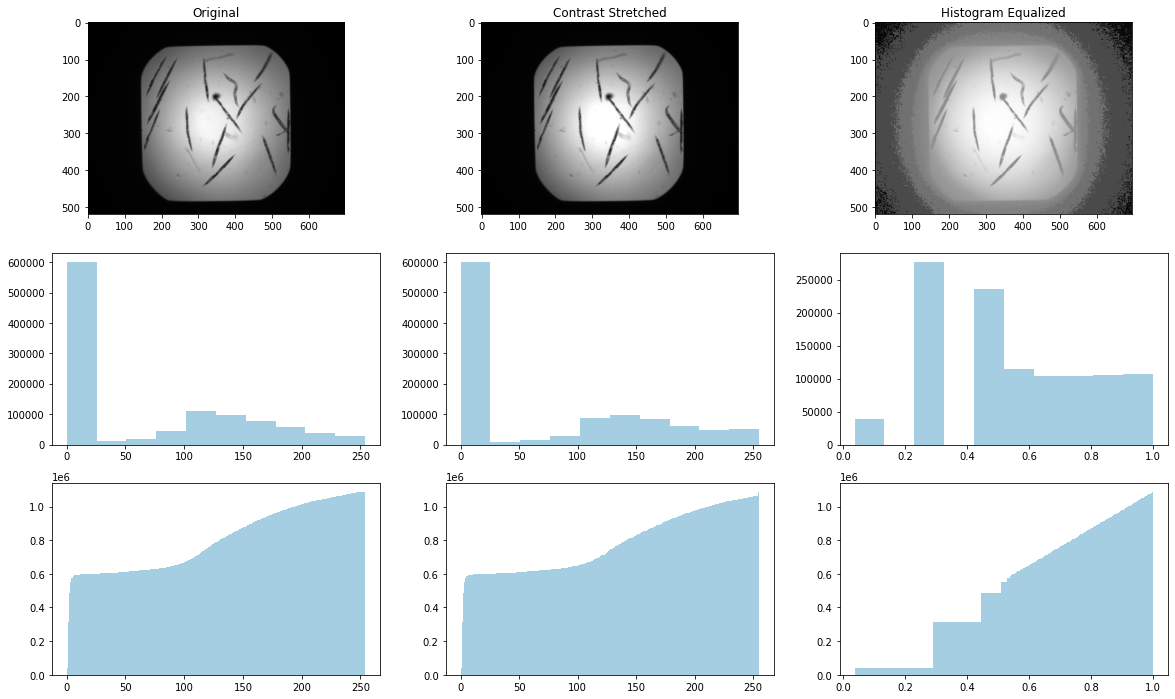

In [408]:
from skimage import exposure
import numpy as np

# Contrast stretching
p2 = np.percentile(image, 2)
p98 = np.percentile(image, 98)
image_ct = exposure.rescale_intensity(image, in_range=(p2, p98))

# Histogram Equalization
image_eq = exposure.equalize_hist(image)

# Show the images
fig = plt.figure(figsize=(20, 12))

# Subplot for original image
a=fig.add_subplot(3,3,1)
imgplot = plt.imshow(image)
a.set_title('Original')

# Subplot for contrast stretched image
a=fig.add_subplot(3,3,2)
imgplot = plt.imshow(image_ct)
a.set_title('Contrast Stretched')

# Subplot for equalized image
a=fig.add_subplot(3,3,3)
imgplot = plt.imshow(image_eq)
a.set_title('Histogram Equalized')

# Subplots for histograms
a=fig.add_subplot(3,3,4)
imgplot = plt.hist(image.ravel())

a=fig.add_subplot(3,3,5)
imgplot = plt.hist(image_ct.ravel())

a=fig.add_subplot(3,3,6)
imgplot = plt.hist(image_eq.ravel())

# Subplots for CDFs

a=fig.add_subplot(3,3,7)
imgplot = plt.hist(image.ravel(), bins=255, cumulative=True)

a=fig.add_subplot(3,3,8)
imgplot = plt.hist(image_ct.ravel(), bins=255, cumulative=True)

a=fig.add_subplot(3,3,9)
imgplot = plt.hist(image_eq.ravel(), bins=255, cumulative=True)

plt.show()

**Contrast-stretching**

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.20)
Accuracy Test: 0.7143 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

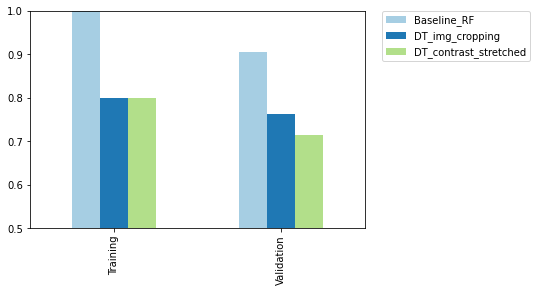

              precision    recall  f1-score   support

        dead       0.89      0.62      0.73        13
        live       0.58      0.88      0.70         8

    accuracy                           0.71        21
   macro avg       0.74      0.75      0.71        21
weighted avg       0.77      0.71      0.72        21

Accuracy: 71.43%

 Confusion Matrix:


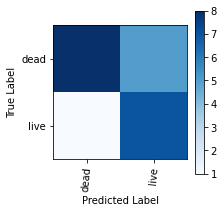

*******************************************************************


In [409]:
def prep_data_contrast_stretching (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                cropped = img[140:445,160:525]

                # Contrast stretching
                p2 = np.percentile(cropped, 2)
                p98 = np.percentile(cropped, 98)
                image_prepped = exposure.rescale_intensity(cropped, in_range=(p2, p98))

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_contrast_stretching(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_contrast_stretched")

The stretching did not bring any improvement versus the baseline.

**Histogram Equalization**

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6750 (+/- 0.16)
Accuracy Test: 0.8095 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

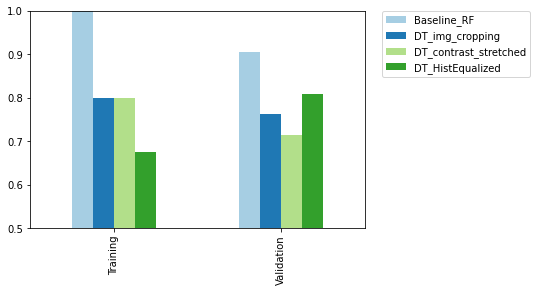

              precision    recall  f1-score   support

        dead       0.85      0.85      0.85        13
        live       0.75      0.75      0.75         8

    accuracy                           0.81        21
   macro avg       0.80      0.80      0.80        21
weighted avg       0.81      0.81      0.81        21

Accuracy: 80.95%

 Confusion Matrix:


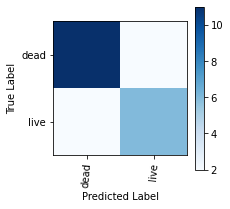

*******************************************************************


In [410]:
def prep_data_hist_eq (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Histogram Equalization
                image_prepped = exposure.equalize_hist(img)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_hist_eq(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_HistEqualized")

Using Histogram Equalizer as a preprocessing step shows an improvement versus our baseline classifier!

### 3.2 Image Filtering

Image Filtering can be used to remove noise or to blur an image. Let's see if it helps in our case: 

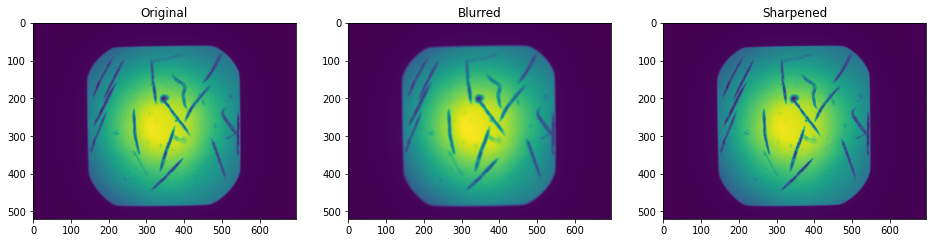

In [411]:
# Using some common filters

from PIL import Image, ImageFilter

# Required magic to display matplotlib plots in notebooks
%matplotlib inline

# Load the image from the source file
image_file = "/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training/dead/1649_1109_0003_Amp5-1_B_20070424_B22_w2_7D06CB6E-9CEC-4B80-BABD-89CCFD5D7D5B.jpg"
image = Image.open(image_file)

blurred_image = image.filter(ImageFilter.BLUR)
sharpened_image = image.filter(ImageFilter.SHARPEN)

# Display it
fig = plt.figure(figsize=(16, 12))

# Plot original image
a=fig.add_subplot(1, 3, 1)
image_plot_1 = plt.imshow(image)
a.set_title("Original")

# Plot blurred image
a=fig.add_subplot(1, 3, 2)
image_plot_2 = plt.imshow(blurred_image)
a.set_title("Blurred")

# Plot sharpened image
a=fig.add_subplot(1, 3, 3)
image_plot_3 = plt.imshow(sharpened_image)
a.set_title("Sharpened")

plt.show()

**Sharpen**

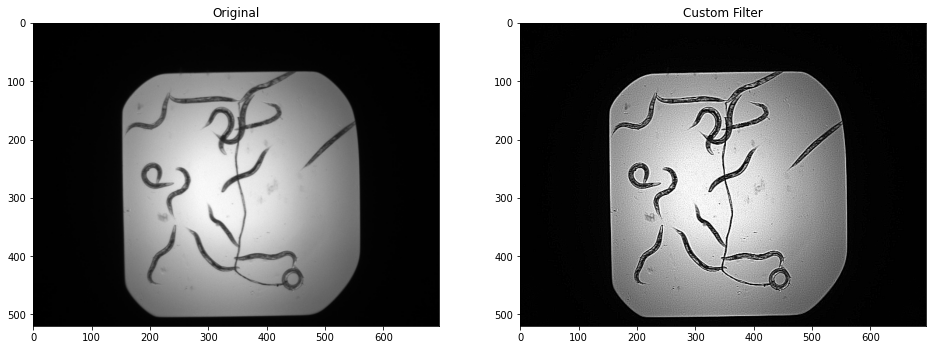

In [412]:
# Let's try our custom sharpener
cv_image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))

filter = np.array([[-1, -1, -1],
                   [-1, 9, -1],
                   [-1, -1, -1]])

filtered_image = cv2.filter2D(cv_image, -1, filter)

# Display it
fig = plt.figure(figsize=(16, 12))

# Plot original image
a=fig.add_subplot(1, 2, 1)
image_plot_1 = plt.imshow(cv_image)
a.set_title("Original")

# Plot filtered image
a=fig.add_subplot(1, 2, 2)
image_plot_2 = plt.imshow(filtered_image)
a.set_title("Custom Filter")

plt.show()

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.7000 (+/- 0.16)
Accuracy Test: 0.7619 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

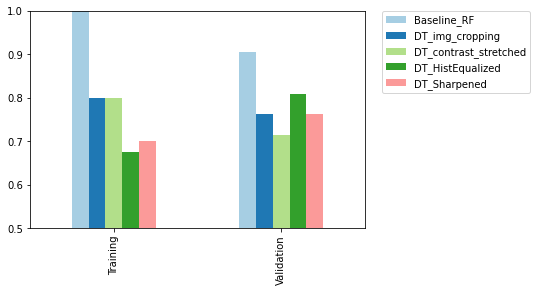

              precision    recall  f1-score   support

        dead       0.90      0.69      0.78        13
        live       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

Accuracy: 76.19%

 Confusion Matrix:


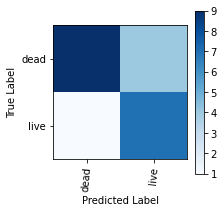

*******************************************************************


In [413]:
from PIL import Image, ImageFilter

def prep_data_sharpen (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Sharpen Image
                #image_prepped = img.filter(ImageFilter.SHARPEN)
                filter = np.array([[-1, -1, -1], 
                                   [-1, 9, -1], 
                                   [-1, -1, -1]])

                image_prepped = cv2.filter2D(img, -1, filter)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_sharpen(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Sharpened")

**Blur**

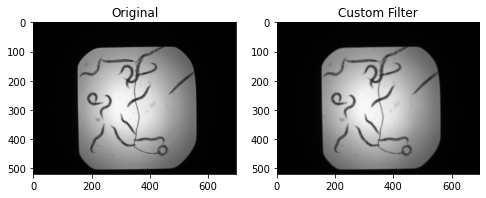

In [414]:
# Let's try our blur
cv_image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))

#filter = np.ones((5,5),np.float32)/25
#filtered_image = cv2.filter2D(cv_image, -1, filter)
filtered_image = cv2.GaussianBlur(cv_image, (5,5),0)

# Display it
fig = plt.figure(figsize=(8, 6))

# Plot original image
a=fig.add_subplot(1, 2, 1)
image_plot_1 = plt.imshow(cv_image)
a.set_title("Original")

# Plot filtered image
a=fig.add_subplot(1, 2, 2)
image_plot_2 = plt.imshow(filtered_image)
a.set_title("Custom Filter")

plt.show()

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6750 (+/- 0.13)
Accuracy Test: 0.8095 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

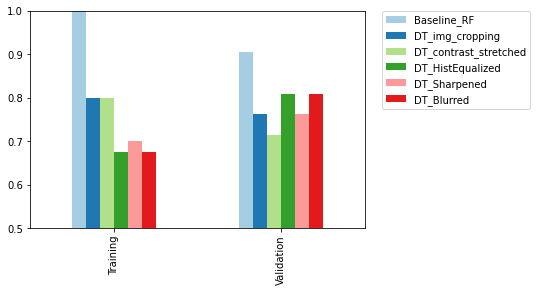

              precision    recall  f1-score   support

        dead       1.00      0.69      0.82        13
        live       0.67      1.00      0.80         8

    accuracy                           0.81        21
   macro avg       0.83      0.85      0.81        21
weighted avg       0.87      0.81      0.81        21

Accuracy: 80.95%

 Confusion Matrix:


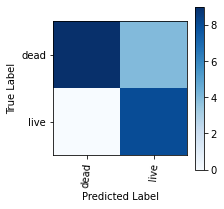

*******************************************************************


In [415]:
def prep_data_blur (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Blurr Image
                #image_prepped = img.filter(ImageFilter.BLUR)
                #kernel = np.ones((5,5),np.float32)/25 #averaging filter
                #image_prepped = cv2.filter2D(img,-1,kernel)
                image_prepped = cv2.GaussianBlur(img, (5,5),0)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_blur(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Blurred")

We see that neither sharpening nor blurring lead to an improvement. It is possible, that playing around with different blur- or sharpener-filters (different filter sizes and values) would lead to a better result, however we will leave as is for now and move on to Edge Detection.

### 3.3 Edge Detection

We are now trying Edge Detection. Edge Detections finds the boundaries or edges of objects in an image by determining those areas of the image where the brightness of the image changes dramatically. It can be used to extract the structure of objects in an image which is helpful to focus on specific parts of the image (e.g. number, size, shape or relative location of objects in the image), while ignoring parts of the image without any structure. Finally, Edge Detection is also used to simplify the image to minimize the amount of data to be processed. 

There are a variety of Edge Detection methods with different underlying calculations and error models. A few of the most popular Edge Detection methods are Prewitt, Canny, Sobel and Laplacian of Gaussian (LoG) - we will try Sobel and Laplacion in this section.

The following image gives a nice overview of different Edge Detection techniques ([Source](https://medium.com/perspectivesondatascience/preprocessing-with-computer-vision-part-v-edge-detection-1b51e37d5d3f))

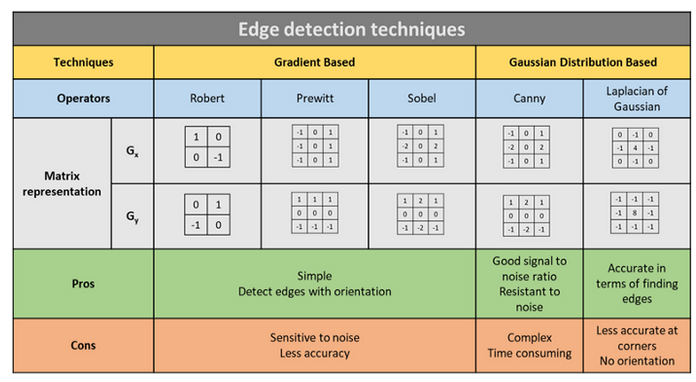

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.3000 (+/- 0.26)
Accuracy Test: 0.3810 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

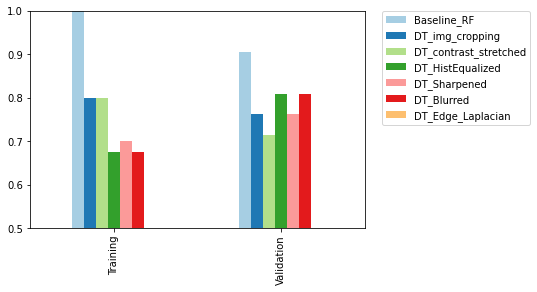

              precision    recall  f1-score   support

        dead       0.50      0.23      0.32        13
        live       0.33      0.62      0.43         8

    accuracy                           0.38        21
   macro avg       0.42      0.43      0.38        21
weighted avg       0.44      0.38      0.36        21

Accuracy: 38.10%

 Confusion Matrix:


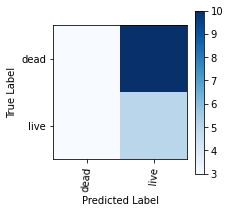

*******************************************************************


In [416]:
## LAPLACIAN
def prep_data_laplacian (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Edge Detection
                image_prepped = cv2.Laplacian(img,cv2.CV_64F)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_laplacian(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Edge_Laplacian")

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6750 (+/- 0.22)
Accuracy Test: 0.7619 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

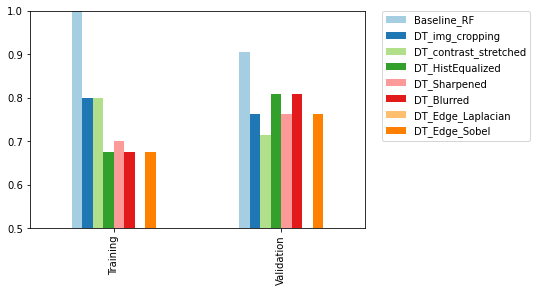

              precision    recall  f1-score   support

        dead       0.90      0.69      0.78        13
        live       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

Accuracy: 76.19%

 Confusion Matrix:


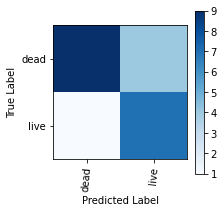

*******************************************************************


In [417]:
## SOBEL
def prep_data_sobel (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525] 

                # Edge Detection
                sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)
                sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)

                #print(sobelx.type)
                #magniture
                sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))
                vis = np.concatenate((img, sobel), axis=0)
                #with only edge info
                #vis=sobel

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(vis.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_sobel(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Edge_Sobel")

### 3.4 Morphological Operations

**Erosion**

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.17)
Accuracy Test: 0.7619 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

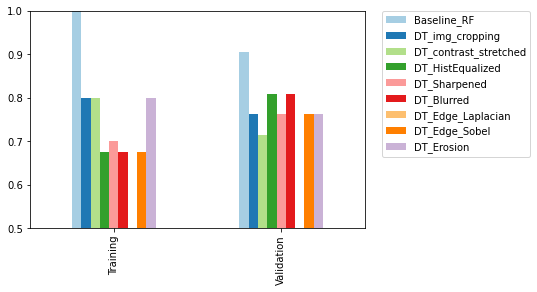

              precision    recall  f1-score   support

        dead       0.83      0.77      0.80        13
        live       0.67      0.75      0.71         8

    accuracy                           0.76        21
   macro avg       0.75      0.76      0.75        21
weighted avg       0.77      0.76      0.76        21

Accuracy: 76.19%

 Confusion Matrix:


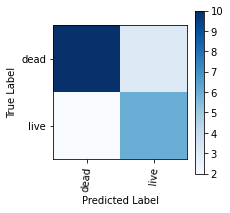

*******************************************************************


In [418]:
## Erosion
def prep_data_erosion (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Erosion
                kernel = np.ones((5,5),np.uint8)
                image_prepped = cv2.erode(img,kernel, iterations=1)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_erosion(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Erosion")

**Dilation**

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.08)
Accuracy Test: 0.9048 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

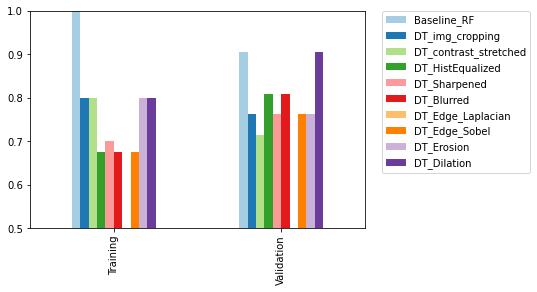

              precision    recall  f1-score   support

        dead       1.00      0.85      0.92        13
        live       0.80      1.00      0.89         8

    accuracy                           0.90        21
   macro avg       0.90      0.92      0.90        21
weighted avg       0.92      0.90      0.91        21

Accuracy: 90.48%

 Confusion Matrix:


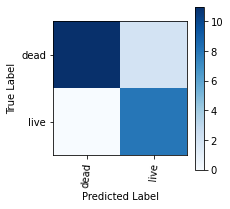

*******************************************************************


In [419]:
## Dilation
def prep_data_dilation (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525] 

                # Dilation
                kernel = np.ones((5,5),np.uint8)
                image_prepped = cv2.dilate(img,kernel, iterations=1)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_dilation(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state= random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Dilation")

**Closing and Opening**

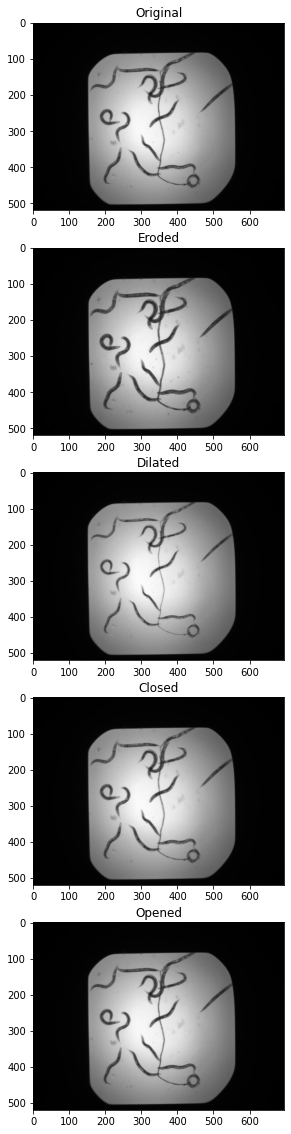

In [420]:
# Let's try what effect opening and closing has
from skimage import io as sk_io, color as sk_col, morphology as sk_mm

bw_image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))

# Apply operations
eroded_image = sk_mm.erosion(bw_image)
dilated_image = sk_mm.dilation(bw_image)
closed_image = sk_mm.closing(bw_image)
opened_image = sk_mm.opening(bw_image)

# Display it
fig = plt.figure(figsize=(20,20))

# Plot original image
a=fig.add_subplot(5, 1, 1)
plt.imshow(bw_image, cmap="gray")
a.set_title("Original")

# Plot eroded image
a=fig.add_subplot(5, 1, 2)
plt.imshow(eroded_image, cmap="gray")
a.set_title("Eroded")

# Plot dilated image
a=fig.add_subplot(5, 1, 3)
plt.imshow(dilated_image, cmap="gray")
a.set_title("Dilated")

# Plot closed image
a=fig.add_subplot(5, 1, 4)
plt.imshow(closed_image, cmap="gray")
a.set_title("Closed")

# Plot opened image
a=fig.add_subplot(5, 1, 5)
plt.imshow(opened_image, cmap="gray")
a.set_title("Opened")

plt.show()

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.9000 (+/- 0.25)
Accuracy Test: 0.7143 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

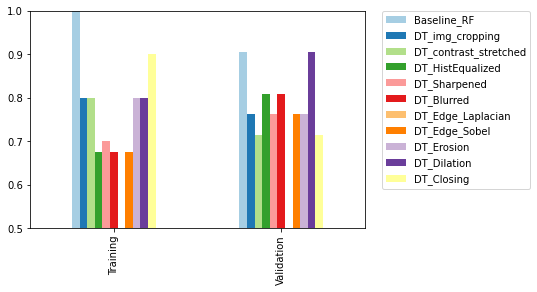

              precision    recall  f1-score   support

        dead       0.82      0.69      0.75        13
        live       0.60      0.75      0.67         8

    accuracy                           0.71        21
   macro avg       0.71      0.72      0.71        21
weighted avg       0.74      0.71      0.72        21

Accuracy: 71.43%

 Confusion Matrix:


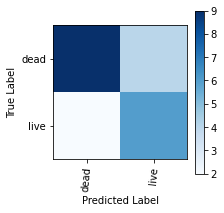

*******************************************************************


In [421]:
## First Dilation, then erosion - Closing
def prep_data_closing (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525] 

                # Closing
                kernel = np.ones((5,5),np.uint8)
                image_prepped = cv2.dilate(img,kernel, iterations=1)
                image_prepped = cv2.erode(image_prepped,kernel, iterations=1)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_closing(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Closing")

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6000 (+/- 0.25)
Accuracy Test: 0.6667 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

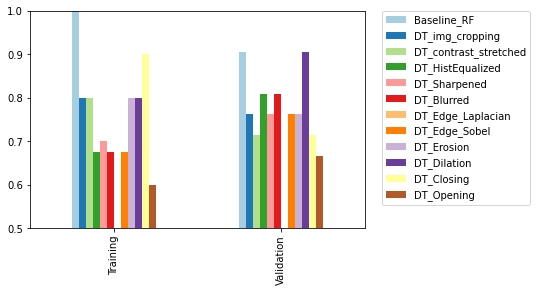

              precision    recall  f1-score   support

        dead       0.75      0.69      0.72        13
        live       0.56      0.62      0.59         8

    accuracy                           0.67        21
   macro avg       0.65      0.66      0.65        21
weighted avg       0.68      0.67      0.67        21

Accuracy: 66.67%

 Confusion Matrix:


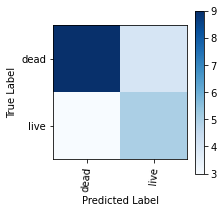

*******************************************************************


In [422]:
## First Erosion, then Dilation - Opening
def prep_data_opening (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Opening
                kernel = np.ones((5,5),np.uint8)
                image_prepped = cv2.erode(img,kernel, iterations=1)
                image_prepped = cv2.dilate(image_prepped,kernel, iterations=1)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_opening(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Opening")

### 3.5 Thresholding

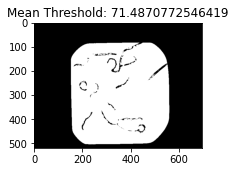

In [423]:
from skimage import io as sk_io, color as sk_col, morphology as sk_mm
from skimage.filters import threshold_mean

%matplotlib inline

# Load the image from the source file
image_file = "/content/gdrive/My Drive/IE/Notebooks/data/voc/plane/008372.jpg"
image = sk_io.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))

# Find the mean threshold value
mean_val = threshold_mean(image)

# Threshold the image
binary_image = image > mean_val

# Plot the thresholded image
fig = plt.figure(figsize=(3,3))
plt.imshow(binary_image, cmap="gray")
plt.title("Mean Threshold: " + str(mean_val))
plt.show()

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.18)
Accuracy Test: 0.7619 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

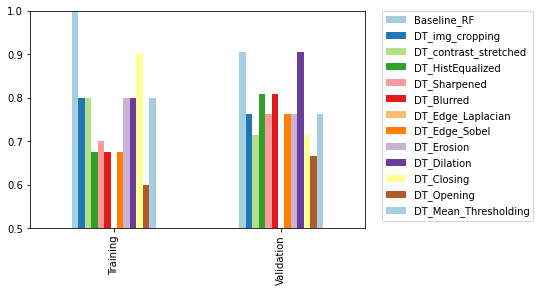

              precision    recall  f1-score   support

        dead       0.90      0.69      0.78        13
        live       0.64      0.88      0.74         8

    accuracy                           0.76        21
   macro avg       0.77      0.78      0.76        21
weighted avg       0.80      0.76      0.77        21

Accuracy: 76.19%

 Confusion Matrix:


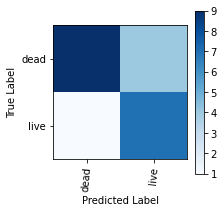

*******************************************************************


In [424]:
## Thresholding

def prep_data_mean_thresh (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Thresholding
                # Find the mean threshold value
                mean_val = threshold_mean(img)

                # Threshold the image
                image_prepped = img > mean_val
 
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_mean_thresh(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Mean_Thresholding")

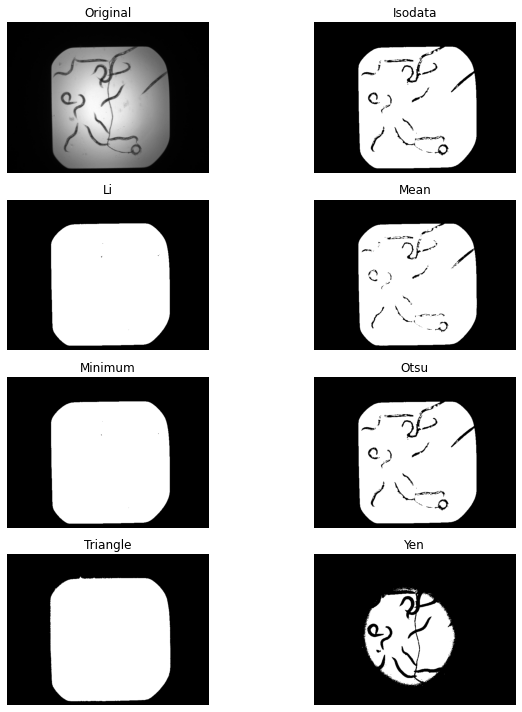

In [425]:
from skimage.filters import try_all_threshold

fig, ax = try_all_threshold(image, figsize=(10, 10), verbose=False)
plt.show()

Let's try Isodata, Otsu and Yen:

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.24)
Accuracy Test: 0.9524 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

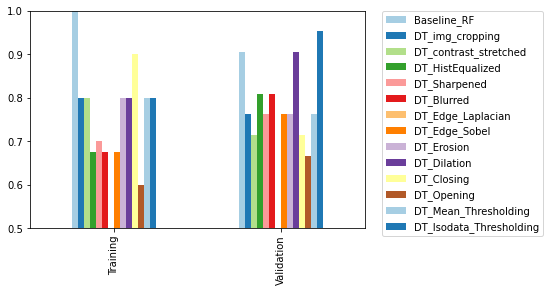

              precision    recall  f1-score   support

        dead       0.93      1.00      0.96        13
        live       1.00      0.88      0.93         8

    accuracy                           0.95        21
   macro avg       0.96      0.94      0.95        21
weighted avg       0.96      0.95      0.95        21

Accuracy: 95.24%

 Confusion Matrix:


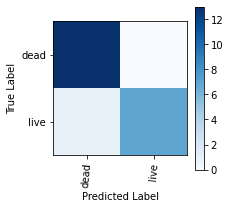

*******************************************************************


In [426]:
## Thresholding - Isodata
from skimage.filters.thresholding import threshold_isodata

def prep_data_isodata_thresh (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Thresholding
                # Find the threshold value
                iso_val = threshold_isodata(img)

                # Threshold the image
                image_prepped = img > iso_val
 
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_isodata_thresh(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Isodata_Thresholding")

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.25)
Accuracy Test: 1.0000 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

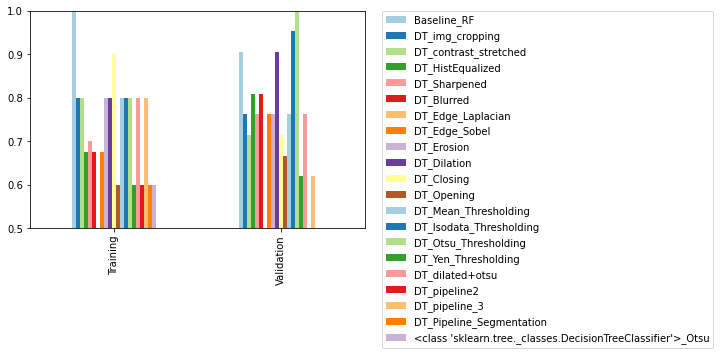

              precision    recall  f1-score   support

        dead       1.00      1.00      1.00        13
        live       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%

 Confusion Matrix:


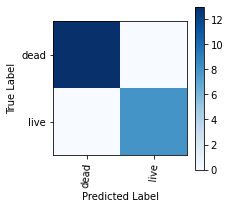

*******************************************************************


In [463]:
## Thresholding - Otsu
from skimage.filters.thresholding import threshold_otsu

def prep_data_otsu_thresh (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Thresholding
                # Find the threshold value
                otsu_val = threshold_otsu(img)

                # Threshold the image
                image_prepped = img > otsu_val
 
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_otsu_thresh(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Otsu_Thresholding")

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6000 (+/- 0.19)
Accuracy Test: 0.6190 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

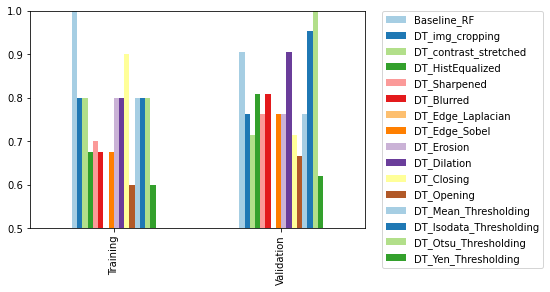

              precision    recall  f1-score   support

        dead       0.65      0.85      0.73        13
        live       0.50      0.25      0.33         8

    accuracy                           0.62        21
   macro avg       0.57      0.55      0.53        21
weighted avg       0.59      0.62      0.58        21

Accuracy: 61.90%

 Confusion Matrix:


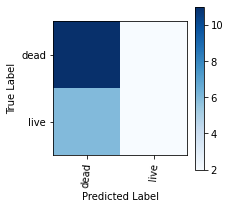

*******************************************************************


In [428]:
## Thresholding - Yen
from skimage.filters.thresholding import threshold_yen

def prep_data_yen_thresh (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Thresholding
                # Find the threshold value
                yen_val = threshold_yen(img)

                # Threshold the image
                image_prepped = img > yen_val
 
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_yen_thresh(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Yen_Thresholding")

### 3.6 Segmentation

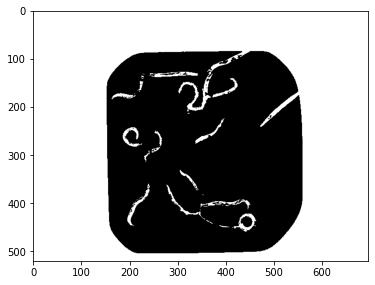

In [429]:
from skimage import color as sk_col
from skimage.filters import threshold_otsu

# Convert to grayscale so we only have one channel
image_otsu = threshold_otsu(image)
thresh_image = image > image_otsu

# Convert the thresholded image to its inverse
inverse_thresh = np.invert(thresh_image)

fig = plt.figure(figsize=(6,6))
plt.imshow(inverse_thresh, "gray")
plt.show()

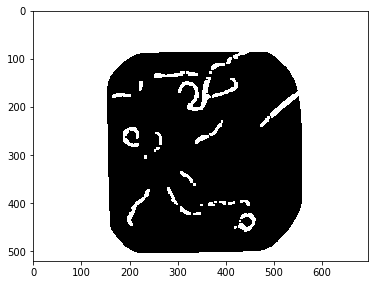

In [430]:
# Use opening and dilation to find the background
kernel = sk_mm.selem.square(3)
opened_thresh = sk_mm.opening(inverse_thresh, kernel)
background = sk_mm.dilation(opened_thresh, kernel)

fig = plt.figure(figsize=(6,6))
plt.imshow(background,cmap="gray", interpolation='nearest')
plt.show()

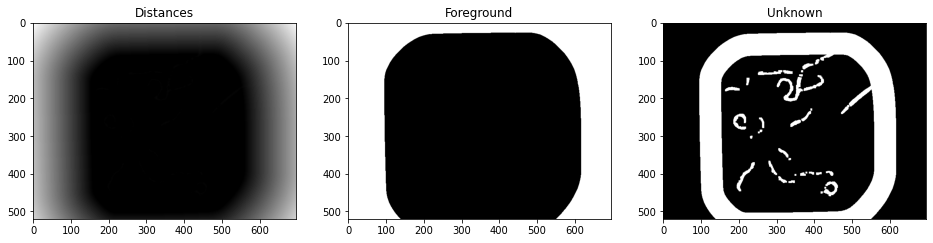

In [431]:
from scipy import ndimage as ndi
distance = ndi.distance_transform_edt(opened_thresh)

foreground_threshold = threshold_otsu(distance)
foreground = distance > foreground_threshold
foreground = np.uint8(foreground)

unknown = background - foreground

fig = plt.figure(figsize=(16,16))

a=fig.add_subplot(1, 3, 1)
plt.imshow(distance, cmap="gray")
a.set_title("Distances")

# Plot eroded image
a=fig.add_subplot(1, 3, 2)
plt.imshow(foreground, cmap="gray")
a.set_title("Foreground")

# Plot eroded image
a=fig.add_subplot(1, 3, 3)
plt.imshow(unknown, cmap="gray")
a.set_title("Unknown")

plt.show()


In [432]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('RF_classifier.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


In [433]:
# Helper function to resize image
def resize_image(src_img, size=(696,520)): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("L", size)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # These are the classes our model can predict
    classnames = ['dead', 'live']
    
    # Predict the class of each input image
    predictions = classifier.predict(image_array)
    
    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


Importing the model


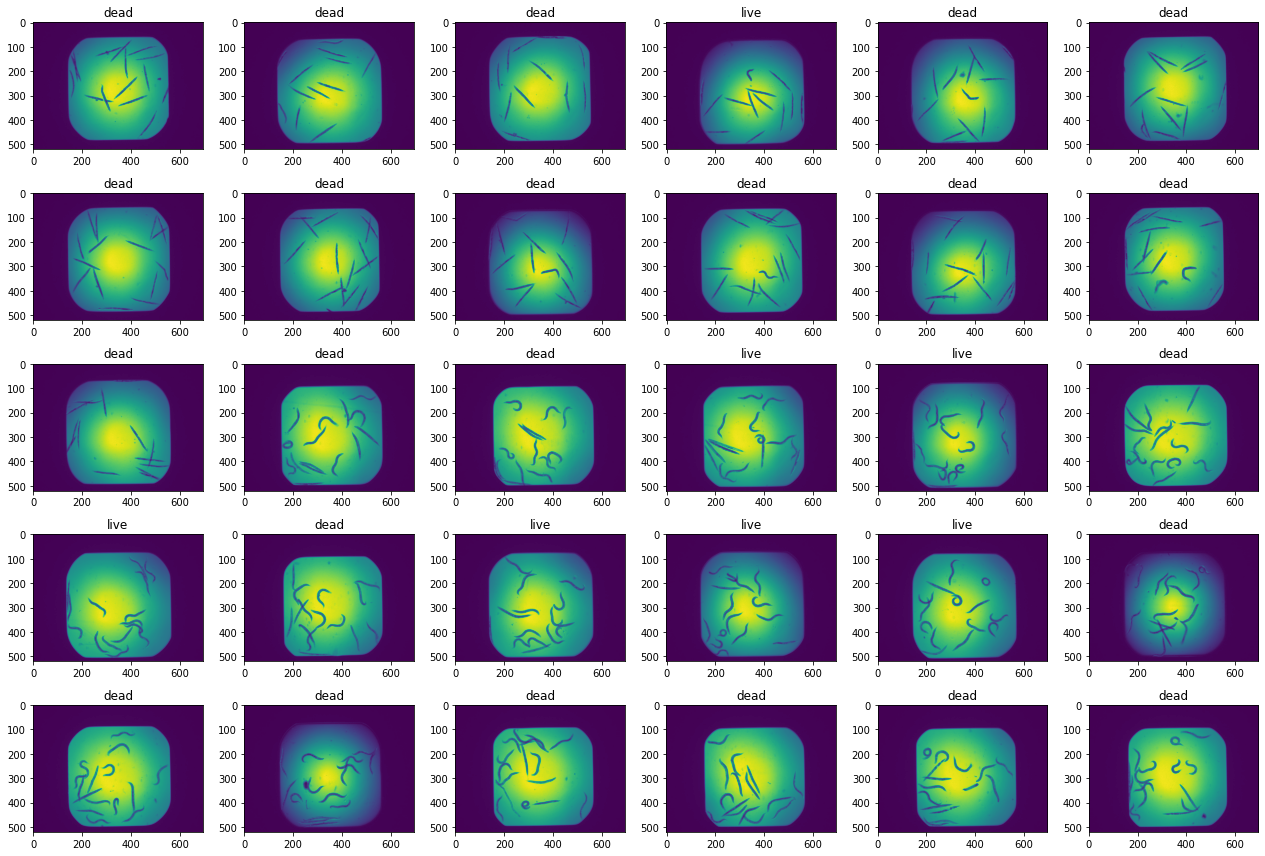

In [434]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('RF_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (696,520)
background_color = "white"

fig = plt.figure(figsize=(18, 12))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size))

    img_shape = np.array(resized_img).shape
                      
    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(5,6, idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    a.set_title(predictions[idx])
    fig.tight_layout()


#image_file_name = img[1]
#plt.title(image_file_name)

## 3. Improve our Model - Image Preprocessing

Let's now see if we can improve our classification model by performing image preprocessing. The underlying assumption is that we can transform our pictures such that the classifier is better able to distinguish differentiating features in the images and thus classification improves.

### 3.1 Testing preprocessing techniques


The following preprocessing techniques had been tested separately within the classification pipeline: 
- Image cropping
- Contrast improvement: Contrast Stretching, Histogram Equalization
- Image filtering: Sharpening, Blurring
- Edge detection: Laplacian, Sobel
- Morphological operations: Erosion,  Dilation, Opening and Closing
- Thresholding: Mean, Isodata, Otsu, Yen
- Segmentation

Results are shown below, the details and code can be found in the Appendix. 

Image 1: Different Preprocessing Techniques (no image cropping)
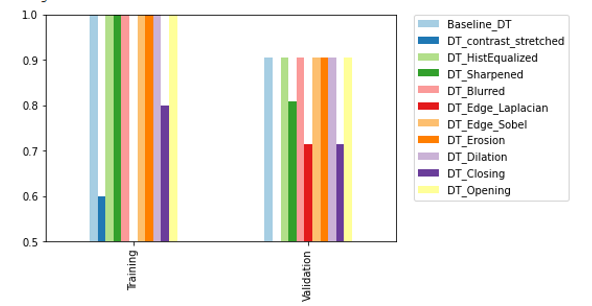


Image 2: Different Preprocessing Techniques (with prior full image cropping)

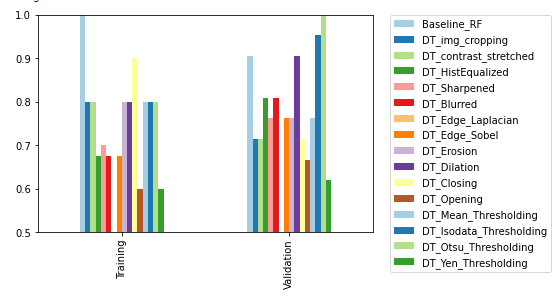

Two important insights were obtained: 
1. It appeared that the black border around the actual images significantly impacts the classifier and distored all preprocessing techniques. None of the preprocessing techniques showed to improve performance versus the baseline classifier (Image 1 above). As a result of this, manual cropping was performed to remove the entire border (which also resulted in cropping parts of the actual image given that the image had rounded edges) with the intent to not leave any parts of the border which the classifier could misread as identifying pattern.  

2. Results were unfortunately not stable. Due to the low number of training images, the results varied significantly with each run. In an attempt to control for the randomness, a random_state was set for the test-training-split, the cross-validation split and the classifier. With different random states, preprocessing techniques either performed equally well as the baseline, performed worse, or performed better. Among the ones that performed better (from time to time), were usually thresholding techniques (mean, isodata or otsu) and morphological operations.

### 3.2 Testing Pipelines

Given above limitations, several preprocessing pipelines were tested with an attempt to identify key features and to identify automatically and remove the black border. 

#### Pipeline 1: Testing Dilation and Otsu Thresholding combined 

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.18)
Accuracy Test: 0.7619 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

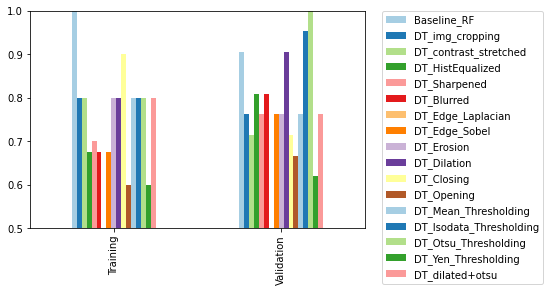

              precision    recall  f1-score   support

        dead       0.79      0.85      0.81        13
        live       0.71      0.62      0.67         8

    accuracy                           0.76        21
   macro avg       0.75      0.74      0.74        21
weighted avg       0.76      0.76      0.76        21

Accuracy: 76.19%

 Confusion Matrix:


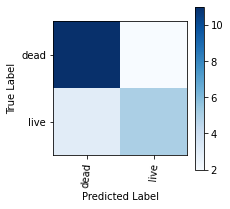

*******************************************************************


In [435]:
## Thresholding - Dilation + Otsu
from skimage.filters.thresholding import threshold_otsu

def prep_data_dilation_otsu (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # Image cropping 
                img = img[140:445,160:525]

                # Dilation
                kernel = np.ones((5,5),np.uint8)
                dilated = cv2.dilate(img,kernel, iterations=1)

                # Thresholding
                # Find the threshold value
                otsu_val = threshold_otsu(dilated)

                # Threshold the image
                image_prepped = img > otsu_val
 
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_dilation_otsu(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_dilated+otsu")

Both combined perform actually worse than even the baseline. 

#### Pipeline 2: Combining Thresholding, Opening and Edge Detection 

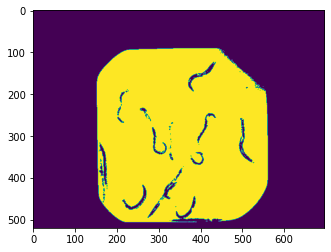

In [436]:
# Load image and convert it to grey
image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_B06_w2_2DC0E4E0-CCDF-4AA3-B655-DC27F2F2E59C.jpg"))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray.astype(np.uint8)

# Apply Otsu Binary Thresholding
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.imshow(thresh)

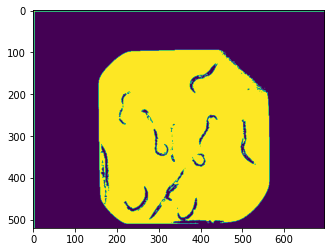

In [437]:
# Morphological Opening
kernel = np.zeros((3,3), dtype = np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(opening)

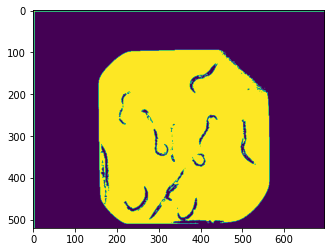

In [438]:
# Sharpen Image
filter = np.array([[-1, -1, -1], 
                    [-1, 9, -1], 
                    [-1, -1, -1]])

#filter = np.array([[1, 1, 1],[1, -8, 1],[1, 1, 1]])

sharpened = cv2.filter2D(opening, -1, filter)

plt.imshow(sharpened)

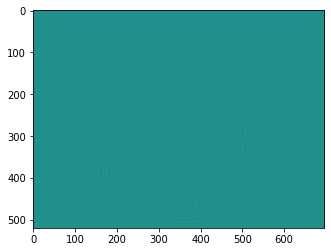

In [439]:
laplacian = cv2.Laplacian(sharpened,cv2.CV_64F)
plt.imshow(laplacian)

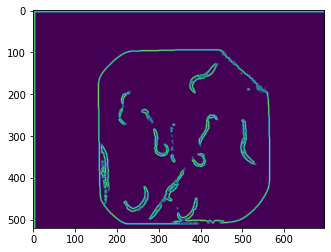

In [440]:
# Edge Detection
sobelx = cv2.Sobel(sharpened,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(sharpened,cv2.CV_64F,0,1,ksize=5)

#magniture
sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))

plt.imshow(sobel)

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6000 (+/- 0.08)
Accuracy Test: 0.3810 (+/- 0.00)


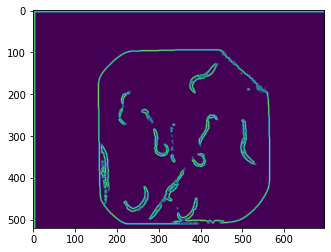

<Figure size 288x360 with 0 Axes>

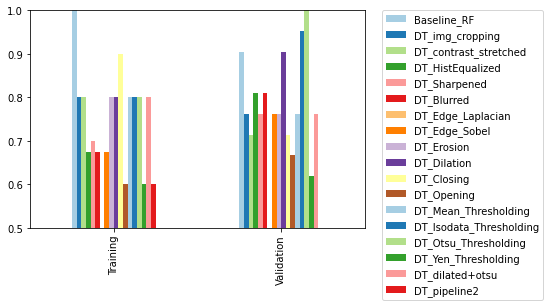

              precision    recall  f1-score   support

        dead       0.00      0.00      0.00        13
        live       0.38      1.00      0.55         8

    accuracy                           0.38        21
   macro avg       0.19      0.50      0.28        21
weighted avg       0.15      0.38      0.21        21

Accuracy: 38.10%

 Confusion Matrix:


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


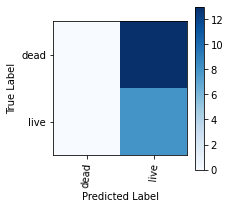

*******************************************************************


In [441]:
### Put above preprocessing steps together into a preprocessing pipeline with the classifier

def prep_data_pipeline_2 (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = cv2.imread(imgFile)

                # Image pipeline
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

                gray.astype(np.uint8)

                # Apply Otsu Binary Thresholding
                thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

                plt.imshow(thresh)

                kernel = np.zeros((3,3), dtype = np.uint8)
                opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

                plt.imshow(opening)

                # Sharpen Image
                filter = np.array([[-1, -1, -1], 
                                    [-1, 9, -1], 
                                    [-1, -1, -1]])

                #filter = np.array([[1, 1, 1],[1, -8, 1],[1, 1, 1]])

                sharpened = cv2.filter2D(opening, -1, filter)

                plt.imshow(sharpened)

                # Edge Detection
                sobelx = cv2.Sobel(sharpened,cv2.CV_64F,1,0,ksize=5)
                sobely = cv2.Sobel(sharpened,cv2.CV_64F,0,1,ksize=5)

                #magniture
                sobel=np.sqrt(np.multiply(sobelx,sobelx)+np.multiply(sobely,sobely))

                plt.imshow(sobel)

                image_prepped = sobel

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_pipeline_2(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_pipeline2")

We can see that our pipeline performs really badly and predicts almost all classes as live. 

#### Pipeline 3: Isolating the worms and remove borders (find contours)

This pipeline was adapted from: https://stackoverflow.com/questions/57997927/how-to-remove-border-edge-noise-from-an-image-using-python

It inverses the image and removes the border created by the black frame such that (theoretically) the classifier should be able to focus only on the worm's patterns. This pipeline appears most promising, however  requires further finetuning (e.g. finding contours) and possibly further preprocessing steps to improve it's accuracy, which is currently only at 67%. 

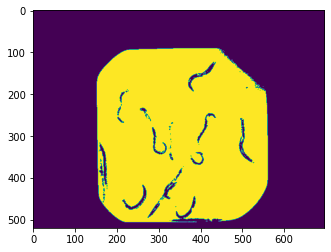

In [442]:
# Load image and convert it to grey
image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_B06_w2_2DC0E4E0-CCDF-4AA3-B655-DC27F2F2E59C.jpg"))
blank_mask = np.zeros(image.shape, dtype=np.uint8)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Otsu Binary Thresholding
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.imshow(thresh)

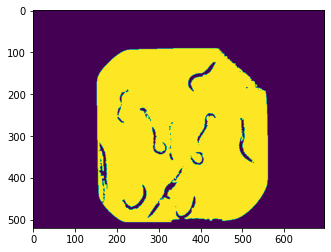

In [443]:
# Remove Artifacts with opening
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening)

# We use a small kernel here since we do not want to dilate aggressively

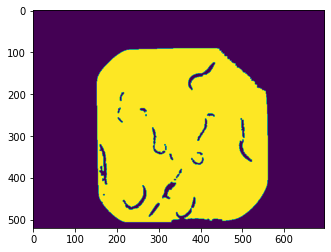

In [444]:
# Fill holes with closing
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations=1)
plt.imshow(closing)

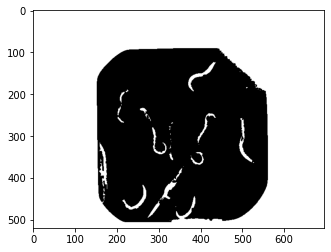

In [445]:
# We inverse the image and perform bitwise operations
inverse = 255 - opening
inverse = cv2.merge([inverse,inverse,inverse])

plt.imshow(inverse)

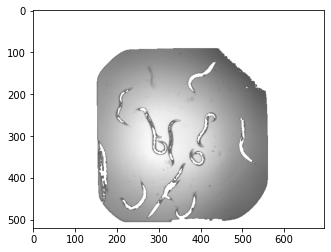

In [446]:
removed_artifacts = cv2.bitwise_and(image,image,mask=opening)
removed_artifacts = cv2.bitwise_or(removed_artifacts, inverse)

plt.imshow(removed_artifacts)

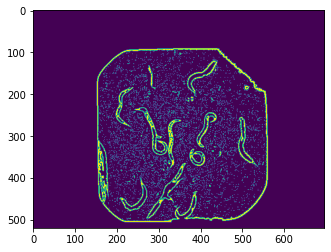

In [447]:
# Isolate worms
worms_gray = cv2.cvtColor(removed_artifacts, cv2.COLOR_BGR2GRAY)
adaptive = cv2.adaptiveThreshold(worms_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,3)

plt.imshow(adaptive)

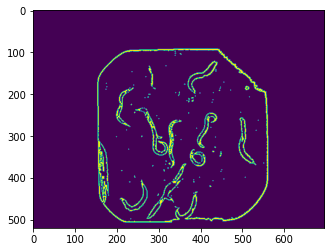

In [448]:
# Remove Artifacts with opening
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
opening_2 = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel, iterations=1)
plt.imshow(opening_2)

# We use a small kernel here since we do not want to dilate aggressively

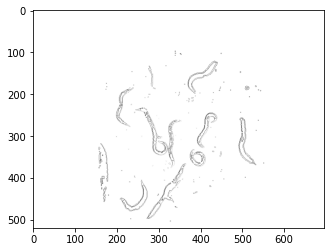

In [449]:
cnts = cv2.findContours(opening_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]

for c in cnts:
    area = cv2.contourArea(c)
    if area < 5000:
        cv2.drawContours(blank_mask, [c], -1, (255,255,255), 1)

blank_mask = cv2.cvtColor(blank_mask, cv2.COLOR_BGR2GRAY)
final = cv2.bitwise_and(image, image, mask=blank_mask)
final[blank_mask==0] = (255,255,255) # White version

plt.imshow(blank_mask)
plt.imshow(final)

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.09)
Accuracy Test: 0.6190 (+/- 0.00)


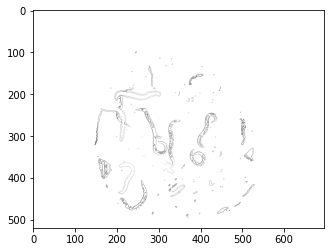

<Figure size 288x360 with 0 Axes>

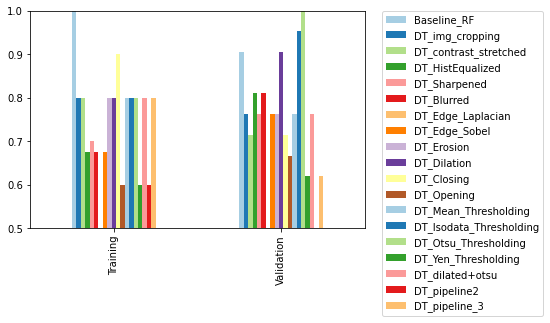

              precision    recall  f1-score   support

        dead       0.78      0.54      0.64        13
        live       0.50      0.75      0.60         8

    accuracy                           0.62        21
   macro avg       0.64      0.64      0.62        21
weighted avg       0.67      0.62      0.62        21

Accuracy: 61.90%

 Confusion Matrix:


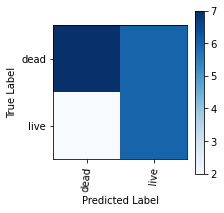

*******************************************************************


In [450]:
### Load images, do preprocessing and then do classifier

def prep_data_pipeline_3 (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = cv2.imread(imgFile)

                # Image pipeline
                blank_mask = np.zeros(img.shape, dtype=np.uint8)
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

                thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
                opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

                inverse = 255 - opening
                inverse = cv2.merge([inverse,inverse,inverse])
                removed_artifacts = cv2.bitwise_and(image,image,mask=opening)
                removed_artifacts = cv2.bitwise_or(removed_artifacts, inverse)

                # Fill holes with closing
                #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
                #closing = cv2.morphologyEx(removed_artifacts, cv2.MORPH_CLOSE, kernel, iterations=1)
                
                # Isolate worms
                worms_gray = cv2.cvtColor(removed_artifacts, cv2.COLOR_BGR2GRAY)
                adaptive = cv2.adaptiveThreshold(worms_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,11,3)

                # Remove Artifacts with opening
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2)) # MORPH_RECT MORPH_ELLIPSE
                opening_2 = cv2.morphologyEx(adaptive, cv2.MORPH_OPEN, kernel, iterations=1)

                cnts = cv2.findContours(opening_2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                cnts = cnts[0] if len(cnts) == 2 else cnts[1]

                for c in cnts:
                    area = cv2.contourArea(c)
                    if area < 3000:
                        cv2.drawContours(blank_mask, [c], -1, (255,255,255), 1)

                blank_mask = cv2.cvtColor(blank_mask, cv2.COLOR_BGR2GRAY)
                final = cv2.bitwise_and(image, image, mask=blank_mask)
                final[blank_mask==0] = (255,255,255) # White version
                image_prepped = final
                plt.imshow(image_prepped)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_pipeline_3(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_pipeline_3")

#### Pipeline 4: Segmentation

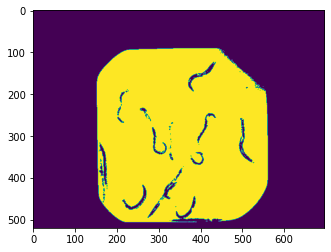

In [451]:
# Load image and convert it to grey
image = cv2.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_B06_w2_2DC0E4E0-CCDF-4AA3-B655-DC27F2F2E59C.jpg"))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

gray.astype(np.uint8)

# Apply Otsu Binary Thresholding
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

plt.imshow(thresh)

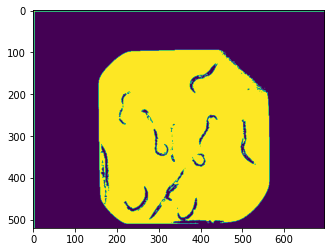

In [452]:
# Morphological Opening
kernel = np.zeros((3,3), dtype = np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

plt.imshow(opening)

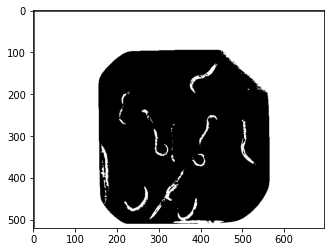

In [453]:
# We inverse the image and perform bitwise operations
inverse = 255 - opening
inverse = cv2.merge([inverse,inverse,inverse])

plt.imshow(inverse)

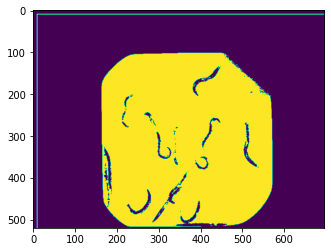

In [454]:
# Sure background area
kernel = np.zeros((15,15), dtype = np.uint8)
sure_bg = cv2.dilate(opening, kernel, iterations=1)

plt.imshow(sure_bg)

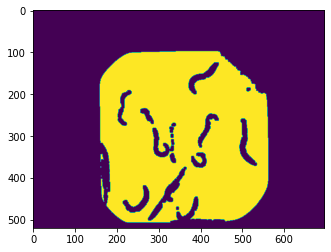

In [455]:
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.05*dist_transform.max(), 255,0, )

plt.imshow(sure_fg)

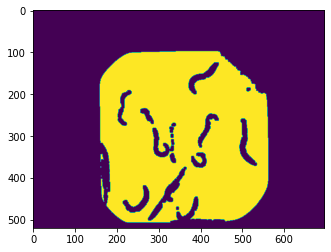

In [456]:
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

plt.imshow(sure_fg)

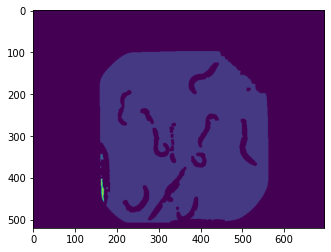

In [457]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

plt.imshow(markers)

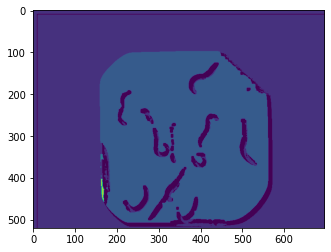

In [458]:
# Add one to all labels so that sure background is not 0 but 1
markers = markers+1

#Now mark the region of unknown with zero
markers[unknown==255] = 0
plt.imshow(markers)

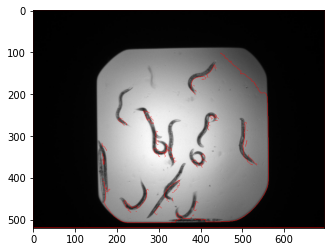

In [459]:
markers = cv2.watershed(image, markers)
image[markers == -1] = [255,0,0]
plt.imshow(image)

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.6000 (+/- 0.08)
Accuracy Test: 0.3810 (+/- 0.00)


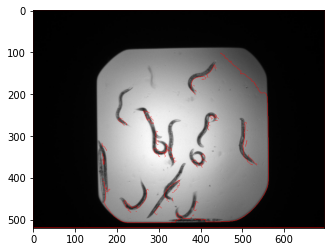

<Figure size 288x360 with 0 Axes>

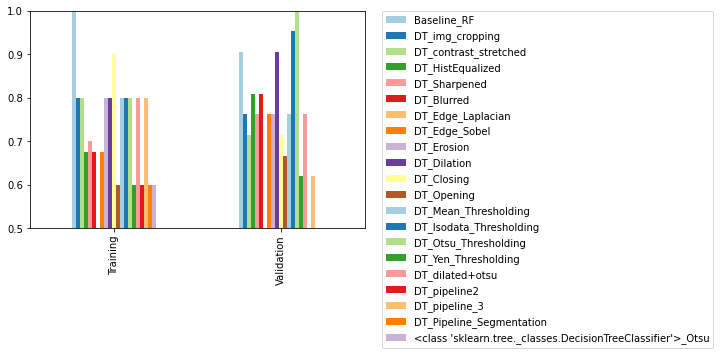

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

        dead       0.00      0.00      0.00        13
        live       0.38      1.00      0.55         8

    accuracy                           0.38        21
   macro avg       0.19      0.50      0.28        21
weighted avg       0.15      0.38      0.21        21

Accuracy: 38.10%

 Confusion Matrix:


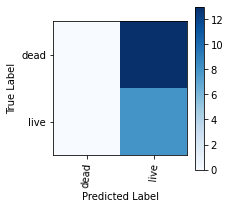

*******************************************************************


In [462]:
## Thresholding - Otsu
from skimage.filters.thresholding import threshold_otsu

def prep_data_segmentation (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = cv2.imread(imgFile)

                # Thresholding
                thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
 
                # Morphological Opening
                kernel = np.zeros((3,3), dtype = np.uint8)
                opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

                # Sure background area
                kernel = np.zeros((15,15), dtype = np.uint8)
                sure_bg = cv2.dilate(opening, kernel, iterations=1)

                # Finding sure foreground area
                dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2,5)
                ret, sure_fg = cv2.threshold(dist_transform, 0.05*dist_transform.max(), 255,0, )

                # Finding unknown region
                sure_fg = np.uint8(sure_fg)
                unknown = cv2.subtract(sure_bg, sure_fg)

                # Marker labelling
                ret, markers = cv2.connectedComponents(sure_fg)

                # Add one to all labels so that sure background is not 0 but 1
                markers = markers+1

                #Now mark the region of unknown with zero
                markers[unknown==255] = 0
                plt.imshow(markers)


                markers = cv2.watershed(image, markers)
                image[markers == -1] = [255,0,0]
                plt.imshow(image)

                image_prepped = image
                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(image_prepped.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_segmentation(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

## Train & Evaluate 
classifier = DecisionTreeClassifier
train_and_evaluate_model(X_train, Y_train, X_test, Y_test, classifier,"DT_Pipeline_Segmentation")

## 4. Fine-tuning

Out of all tested preprocessing techniques, using Image-cropping+Otsu Thresholding yielded best results and as thus, we will choose those two techniques for preprocessing and proceed with finetuning our classifier by testing different classification techniques.  

- Decision Tree
- Random Forest
- Log Regression


Further classifiers are available but were not tested: Boosting Algorithms, KNN, SVM, Naive Bayes

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Accuracy Train: 0.8000 (+/- 0.25)
Accuracy Test: 1.0000 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

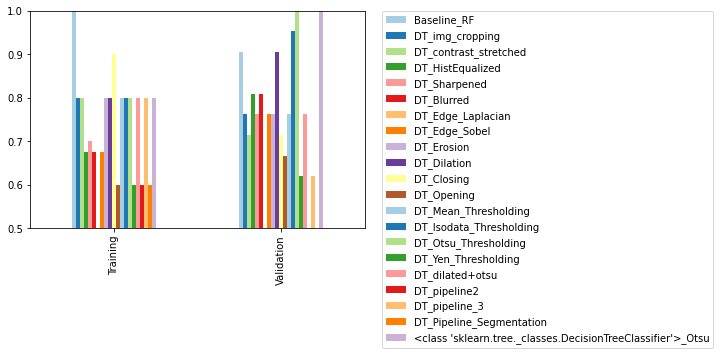

              precision    recall  f1-score   support

        dead       1.00      1.00      1.00        13
        live       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%

 Confusion Matrix:


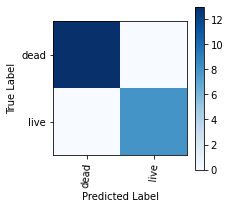

*******************************************************************
Classifier Metrics: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy Train: 1.0000 (+/- 0.13)
Accuracy Test: 1.0000 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

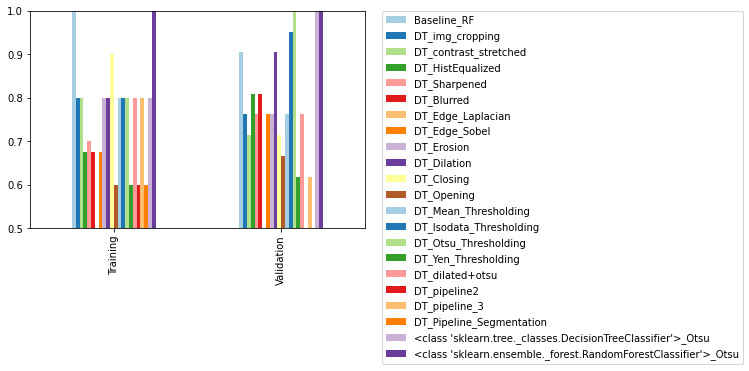

              precision    recall  f1-score   support

        dead       1.00      1.00      1.00        13
        live       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%

 Confusion Matrix:


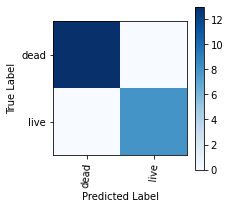

*******************************************************************
Classifier Metrics: <class 'sklearn.linear_model._logistic.LogisticRegression'>
Accuracy Train: 1.0000 (+/- 0.10)
Accuracy Test: 1.0000 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

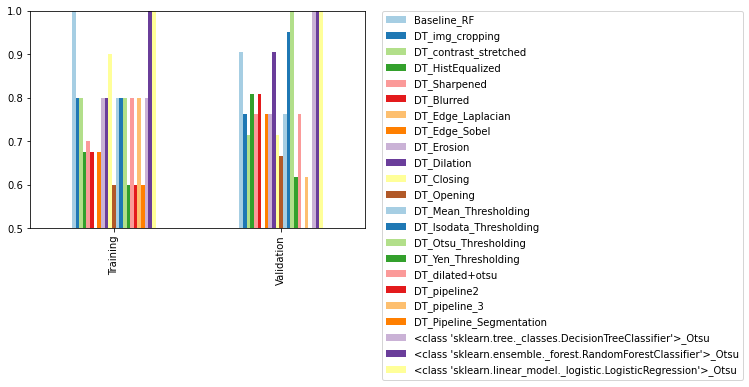

              precision    recall  f1-score   support

        dead       1.00      1.00      1.00        13
        live       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%

 Confusion Matrix:


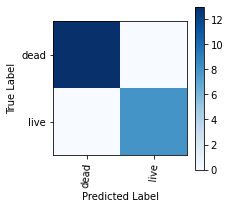

*******************************************************************


In [464]:
# Fine-tuning the model  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB, ComplementNB

# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_otsu_thresh(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state = random_state)

## Test different classifiers: 

classifier_list = [DecisionTreeClassifier,RandomForestClassifier,LogisticRegression] #,GaussianNB,ComplementNB, svm; NearestNeighbor (no attribute predict)

for i in classifier_list:
  train_and_evaluate_model(X_train, Y_train, X_test, Y_test, i,str(i)+"_Otsu")

At the current Random State, all three Classifiers perform equally well. We'll go with the Random Forest (to further battle the randomness by averaging across several trees). Let's see if we can tweak the hyperparameters to improve performance of our random forest.

**Fine-tune Random Forest**

Given that the current model is already predicting with 100% accuracy, we focus on those hyperparameters that make our model more robust - n_estimators and max_depth. 

Reading data from dead
Reading data from live
Classifier Metrics: <class 'sklearn.ensemble._forest.RandomForestClassifier'>
Accuracy Train: 1.0000 (+/- 0.13)
Accuracy Test: 1.0000 (+/- 0.00)


<Figure size 288x360 with 0 Axes>

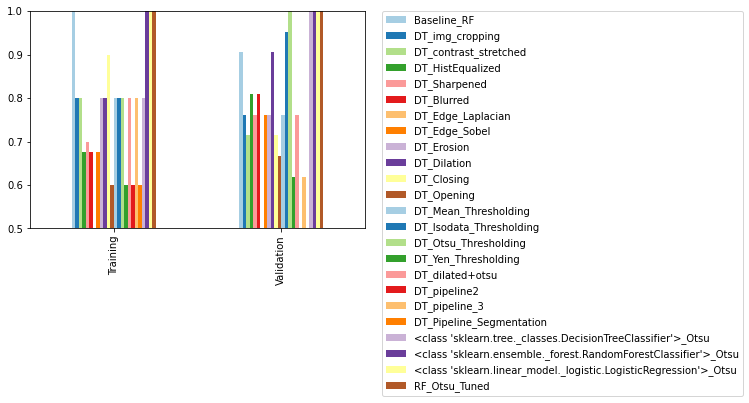

              precision    recall  f1-score   support

        dead       1.00      1.00      1.00        13
        live       1.00      1.00      1.00         8

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Accuracy: 100.00%
*******************************************************************


In [483]:
# Convert the training and test features to floats so they can be scaled
# Train and evaluate the model
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import accuracy_score


# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data_otsu_thresh(training_folder_name)

# split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30, random_state=random_state)

# Convert the training and test features to floats so they can be scaled
# Train and evaluate the model

X_train_float = X_train.astype('float64')
X_test_float = X_test.astype('float64')

classifier = RandomForestClassifier


# Train and evaluate model 
classifier_name = "RF_Otsu_Tuned"
img_pipeline = Pipeline([('norm', MinMaxScaler()),
                         ('classify', RandomForestClassifier(n_estimators=200, max_depth=5, random_state=random_state)),
                         ])

# Use the pipeline to fit a model to the training data
clf = img_pipeline.fit(X_train_float, Y_train)
cv_scores = cross_val_score(clf,
                            X_train_float, Y_train, 
                            scoring = "accuracy", 
                            cv = 10)
predicted = accuracy_score(Y_test, clf.predict(X_test_float))

# Evaluate classifier
print('Classifier Metrics:', classifier)
    
print("Accuracy Train: %0.4f (+/- %0.2f)" % (np.median(cv_scores), np.std(cv_scores)))
print("Accuracy Test: %0.4f (+/- %0.2f)" % (np.median(predicted), np.std(predicted)))
comparing_plot(classifier_result, classifier_name, np.median(cv_scores), np.median(predicted))
    
#predictions = clf.predict(X_test_float)
print(metrics.classification_report(Y_test, clf.predict(X_test_float), target_names=classnames))
print('Accuracy: {:.2%}'.format(metrics.accuracy_score(Y_test, clf.predict(X_test_float))))
print('*******************************************************************')


# Possible params
#param_grid = {"classifier__n_estimators": [200],    # default: 100
              #"classifier__min_samples_split": [2], #[2,4,6],          # default: 2 
              #"classifier__min_samples_leaf": [1,3,5],                 # default: 1
              #"classifier__max_features": ["log2"], #,"auto","log2"],  # default: auto
              #"classifier__bootstrap": [False],                         # default: True
              #"classifier__max_depth": [3],
              #"classifier__verbose": [2]
              #"classifier__max_samples": [0.9],
              #}

## 5. Save the classifier

In [484]:
# Save the trained model
import sys
import os
import pickle

print ("Exporting the model")
file_stream = open('RF_classifier.pkl', 'wb')
pickle.dump(clf, file_stream)
file_stream.close()

Exporting the model


## 6. Predict Image Classes

In [485]:
# Get image size after cropping
image = sk_io.imread(os.path.join(training_folder_name, "live", "1649_1109_0003_Amp5-1_B_20070424_A03_w2_34A7CFCA-A90C-4CB8-9D3E-1BB11081ABE1.jpg"))
cropped = image[140:445,160:525]
cropped.shape

(305, 365)

In [486]:
# Helper function to resize image
def resize_image(src_img, size=(305, 365)): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("L", size)
    #new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
    import numpy as np
    
    # These are the classes our model can predict
    classnames = ['dead', 'live']
    
    # Predict the class of each input image
    predictions = classifier.predict(image_array)
    
    predicted_classes = []
    for prediction in predictions:
        # And append the corresponding class name to the results
        predicted_classes.append(classnames[int(prediction)])
    # Return the predictions
    return predicted_classes

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


Importing the model


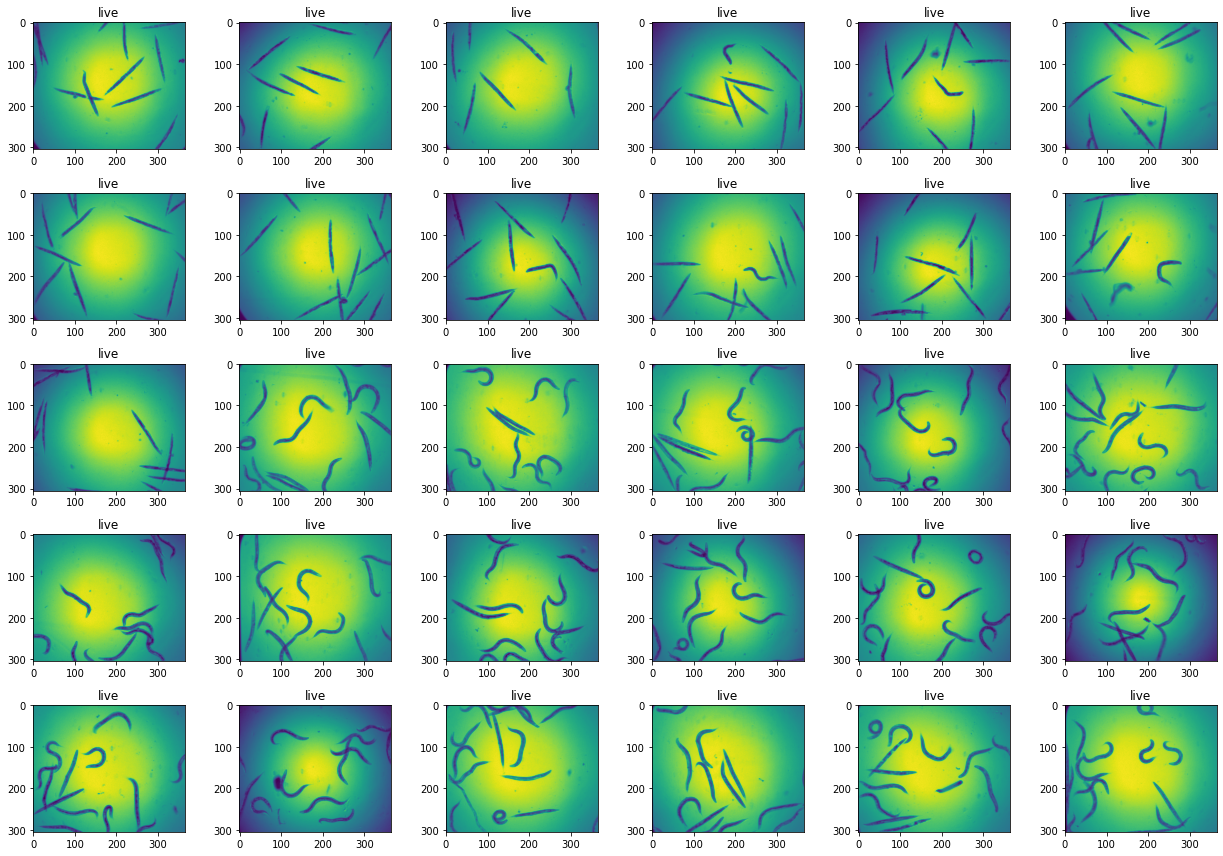

In [487]:
import os
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# Load the model
print("Importing the model")
file_stream = open('RF_classifier.pkl', 'rb')
clf = pickle.load(file_stream)
file_stream.close()

#get the list of test image files
test_folder = '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (305, 365)
background_color = "white"

fig = plt.figure(figsize=(18, 12))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = plt.imread(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    #resized_img = np.array(resize_image(img, size))

    resized_img = np.array(img[140:445,160:525])

    img_shape = np.array(resized_img).shape
                      
    # Add the image to the array of images
    image_arrays.append(resized_img.ravel())

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(clf, np.array(image_arrays))

# plot each image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(5,6, idx+1)
    img = image_arrays[idx].reshape(img_shape)
    imgplot = plt.imshow(img)
    a.set_title(predictions[idx])
    fig.tight_layout()


#image_file_name = img[1]
#plt.title(image_file_name)


We can see that the model heavily overfits and only predicts live class.  As mentioned throughout this notebook, this is most likely due to the low amount of training data.

Interestingly, when using only image cropping (without Otsu thresholding), we would have created an almost perfect classifier (as can be seen in the following image) : 

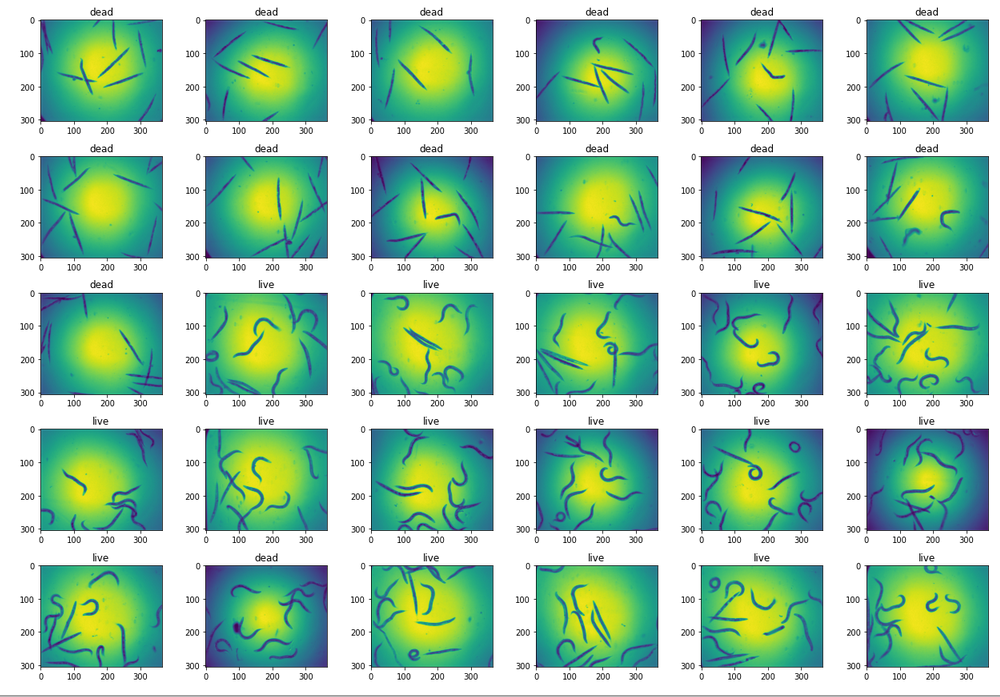

## Appendix: Data augmentation (WIP)

Image data augmentation is typically only applied to the training dataset, and not to the validation or test dataset. This is different from data preparation such as image resizing and pixel scaling; they must be performed consistently across all datasets that interact with the model.

In [ ]:
def prep_data (folder):
    # iterate through folders, assembling feature, label, and classname data objects
    import os
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
    import cv2


    class_id = 0
    features = []
    labels = np.array([])
    classnames = []
    for root, dirs, filenames in os.walk(folder):
        for d in sorted(dirs):
            print("Reading data from", d)
            # use the folder name as the class name for this label
            classnames.append(d)
            files = os.listdir(os.path.join(root,d))
            for f in files:
                # Load the image file
                imgFile = os.path.join(root,d, f)
                img = plt.imread(imgFile)

                # The image array is a multidimensional numpy array
                # - flatten it to a single array of pixel values for scikit-learn
                # - and add it to the list of features
                features.append(img.ravel())
                
                # Add it to the numpy array of labels
                labels = np.append(labels, class_id )
            class_id  += 1
            
    # Convert the list of features into a numpy array
    features = np.array(features)
    
    return features, labels, classnames


# The images are in a folder named 'AssignmentData_Adapted/training'
training_folder_name =  '/content/gdrive/MyDrive/Computer Vision/Individual Assignment/AssignmentData_Adapted/training'

# Prepare the image data
features, labels, classnames = prep_data(training_folder_name)
print(len(features), 'features')
print(len(labels), 'labels')
print(len(classnames), 'classes:', classnames)

In [ ]:
features.shape

In [ ]:
for x in features:
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

In [ ]:
# Following: https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# convert the data into a NumPy array, then preprocess it by scaling
# all pixel intensities to the range [0, 1]

features = np.array(features, dtype="float") / 255.0


# split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size=0.30)

print('Training records:',Y_train.size)
print('Test records:',Y_test.size)


# initialize an our data augmenter as an "empty" image data generator
aug = ImageDataGenerator()

# check to see if we are applying "on the fly" data augmentation, and
# if so, re-instantiate the object
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

In [ ]:
# initialize the optimizer and model
print("[INFO] compiling model...")


# "Compile" model
model = DecisionTreeClassifier()

INIT_LR = 1e-1
BS = 8
EPOCHS = 50

# Train model.
print("[INFO] training network for {} epochs...".format(EPOCHS))
H = model.fit(
	x=aug.flow(X_train, Y_train, batch_size=BS),
	validation_data=(X_test, Y_test),
	steps_per_epoch=len(X_train) // BS,
	epochs=EPOCHS)
